In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm

from src.utils import SimpleDatasetMaker
from src.models import RecurrentSpaceNet

from scipy import stats

In [2]:
## Training parameters
train_steps = 20000

n_in = 2 # Cartesian coordinates, no context
n_out = 100 # no. of spatial representations
scale = 0.3
timesteps = 250
bs = 64 # batch size
lr = 1e-4 # learning rate

In [3]:
# instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in = n_in, n_out = n_out, corr_across_space= False,
                          scale = scale, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

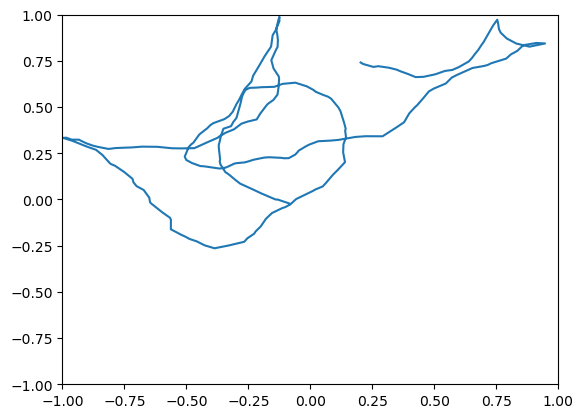

In [4]:
genny = SimpleDatasetMaker()
r, v = genny.generate_dataset(1, timesteps)
plt.plot(*r.detach().numpy().T)
plt.axis([-1, 1, -1, 1])
plt.show()

In [5]:
loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    loss = model.train_step(x = v, y = r[:,1:], optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.021219: 100%|██████████| 20000/20000 [1:26:25<00:00,  3.86it/s]   


Text(0, 0.5, 'Train Loss')

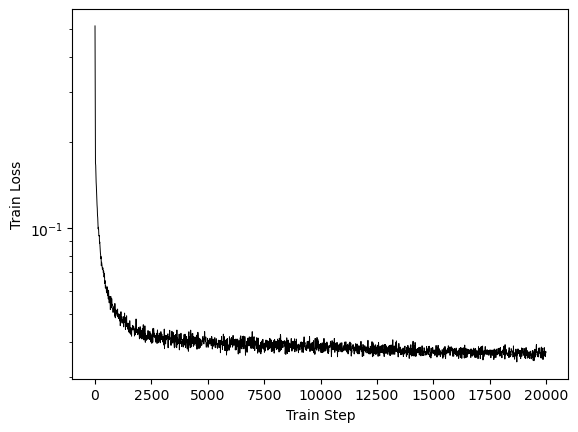

In [6]:
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [16]:
r, v = genny.generate_dataset(100, timesteps)
# inference
model.device = "cpu"
model.to(model.device)
p,_ = model.spatial_representation(v, model.initial_state(v.shape[0]))
p = p.detach().numpy()

In [17]:
r.shape

torch.Size([100, 250, 2])

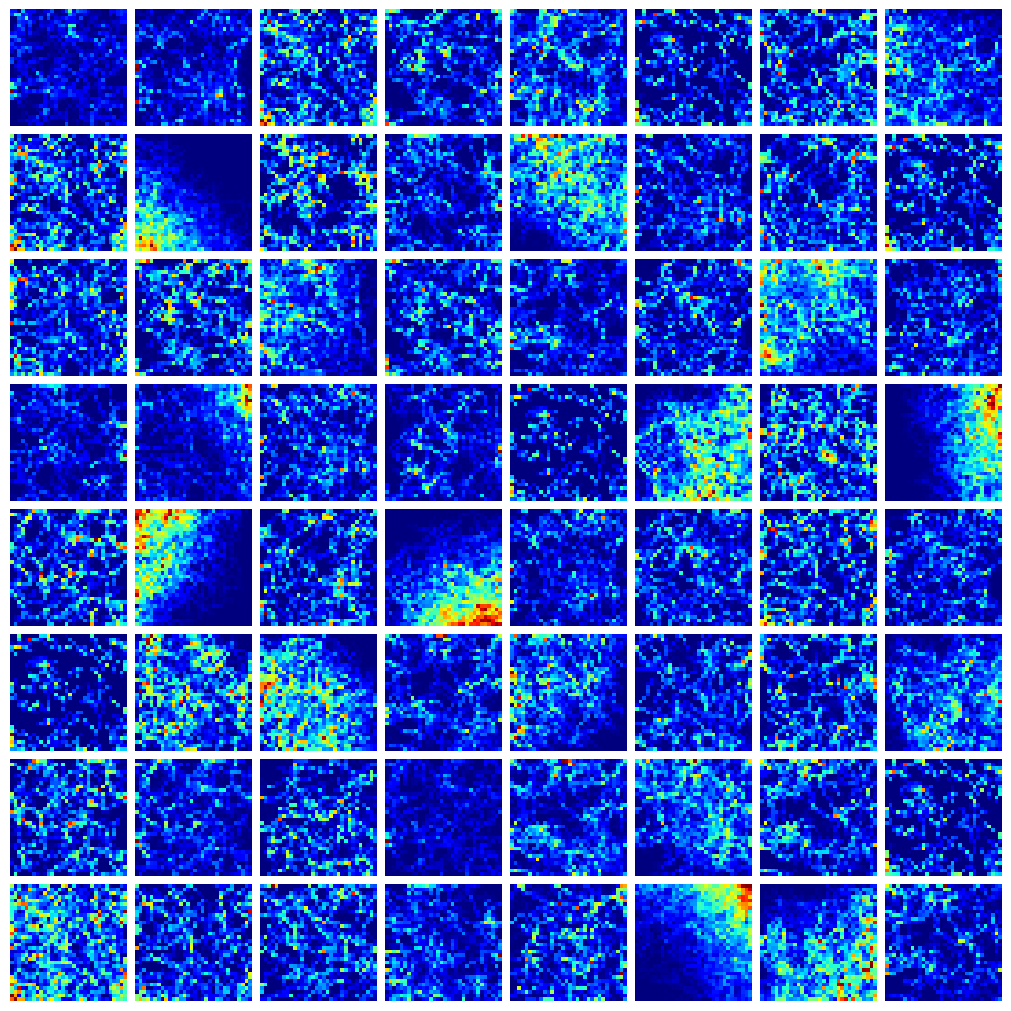

: 

In [18]:
n_show = 8 # show all units in network

fig, ax = plt.subplots(n_show, n_show, figsize = (10,10), constrained_layout = True)

ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)

for i in range(n_show**2):
    ax[i//n_show, i%n_show].imshow(ratemaps[i].T, origin = "lower", cmap = "jet")
    ax[i//n_show, i%n_show].axis("off")

In [10]:
label_corr = model.correlation_function(r[:,:-1]).detach().numpy()
corr, p = model(v)
corr = corr.detach().numpy()
loss = (corr - label_corr)**2

In [11]:
corr.shape, p.shape

((1, 12499, 12499), torch.Size([1, 12499, 100]))

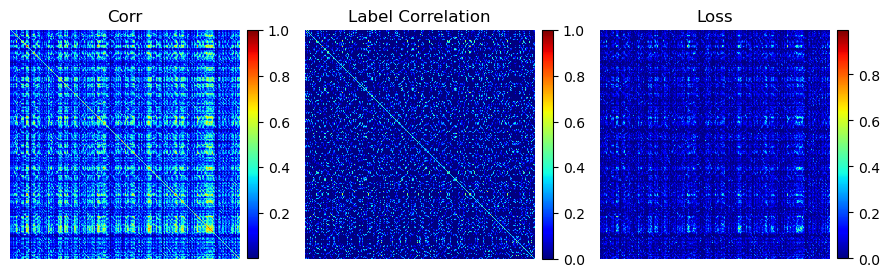

In [12]:
fig, ax = plt.subplots(1,3, figsize = (9, 3))

for i, (val, title) in enumerate(zip([corr, label_corr, loss], ["Corr", "Label Correlation", "Loss"])):
    im = ax[i].imshow(np.mean(val, axis = 0), cmap = "jet")
    ax[i].set_title(title)
    ax[i].axis("off")
    fig.colorbar(im, ax = ax[i], pad = 0.03, fraction = 0.046) 
plt.tight_layout()

Text(0, 0.5, 'Activity')

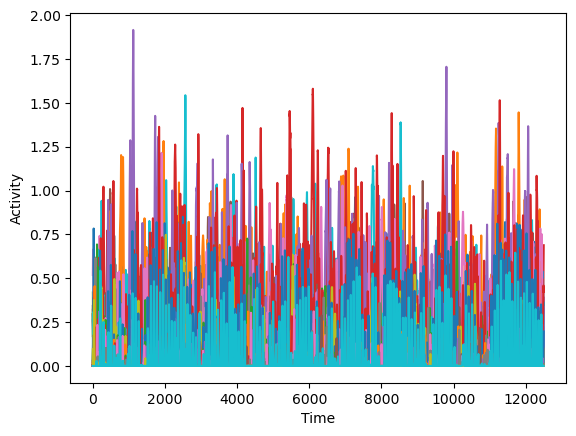

In [13]:
plt.plot(np.mean(p.detach().numpy(),axis=0));
plt.xlabel("Time")
plt.ylabel("Activity")

In [14]:
ratemaps.shape

(100, 32, 32)

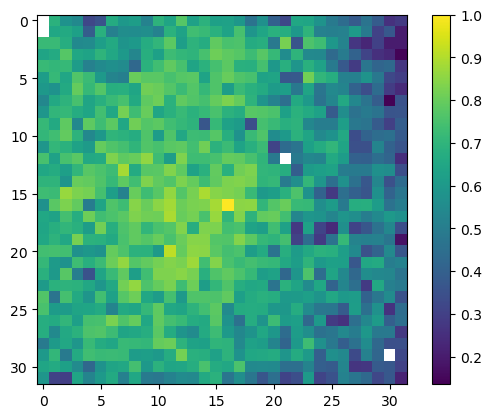

In [15]:

z = np.exp(-np.sum((ratemaps[:,16,16,None,None] - ratemaps)**2, axis = 0))
plt.imshow(z.reshape(32,32))
plt.colorbar()